In [1]:
import os
import glob
from functools import reduce

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
run_name = "wlc"

## Client side stats

In [4]:
# read in the data
plot_data_list = []

for i in glob.glob("./results/" + run_name + "/httperf_client_*.csv"):
    plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

In [5]:
plot_data = pd.DataFrame()

if len(plot_data_list) > 0:
    for i in list(plot_data_list[0]):
        if not i.startswith('Response time'):
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])
        else:
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] 
                                                       for j in range(len(plot_data_list))]) / len(plot_data_list)

plot_data.head()

,Response time 66%,Response status 4xx,Response rate 99%,Response time 50%,Response time 99%,Response rate 66%,Response rate 75%,Response time,Number of requests,Response rate 90%,...,Response rate 98%,Response time 98%,Request rate,Response time 90%,Response status 5xx,Response status 2xx,Response time 80%,Response rate 50%,Rate,Response rate 95%
0,14.25,0,195.0,12.75,447.0,185.0,187.0,31.8375,3840,191.0,...,195.0,348.0,190.3,16.875,0,3840,15.0,184.0,192,194.0


### 1. Request rate

In [6]:
rr_plot_data = plot_data[['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                          'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                          'Response rate 99%', 'Response rate 100%']]
rr_plot_data

,Request rate,Response rate 50%,Response rate 66%,Response rate 75%,Response rate 80%,Response rate 90%,Response rate 95%,Response rate 98%,Response rate 99%,Response rate 100%
0,190.3,184.0,185.0,187.0,188.0,191.0,194.0,195.0,195.0,203.0


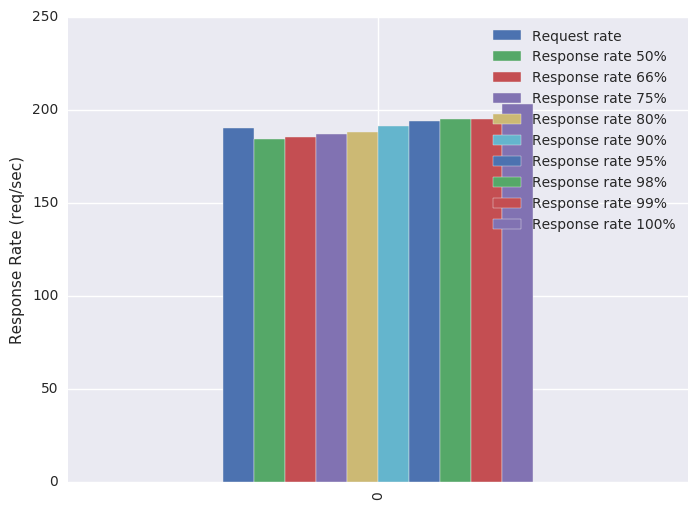

In [7]:
rr_plot_data.plot(ylim=(0, None), kind='bar').set_ylabel("Response Rate (req/sec)")

In [8]:
rr_plot_data.to_csv("./results/" + run_name + "/wlc_response_rate.csv")

### 1. Request time

In [9]:
rt_plot_data = plot_data[['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                          'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                          'Response time 99%', 'Response time 100%']]
rt_plot_data

,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,31.8375,12.75,14.25,14.75,15.0,16.875,139.0,348.0,447.0,554.875


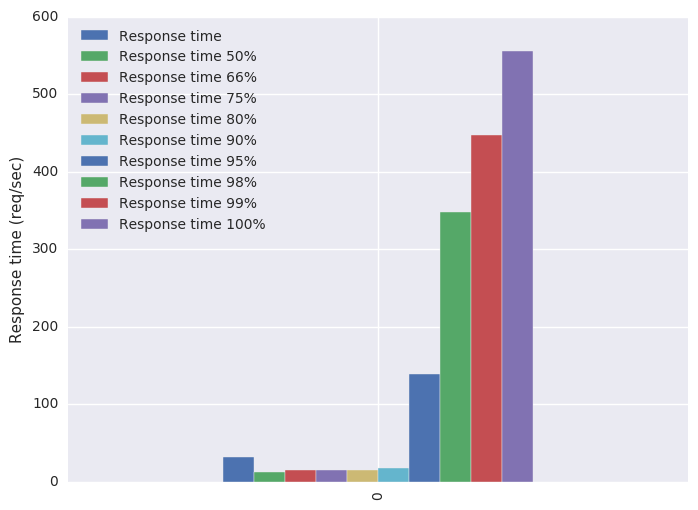

In [10]:
rt_plot_data.plot(ylim=(0, None), kind='bar').set_ylabel("Response time (req/sec)")

In [11]:
plot_data.to_csv("./results/" + run_name + "/wlc_response_time.csv")

### 3. Success rate

In [12]:
sr_plot_data = (plot_data['Response status 2xx'] + plot_data['Response status 3xx']) / plot_data['Number of requests'] * 100.0
sr_plot_data

0    100.0
dtype: float64

## Server side stats

In [13]:
# read in the stats data
stats_data = pd.read_csv("./results/" + run_name + "/httperf_server_stats.csv", header=0, na_filter=False)
stats_data['Connections Ratio (%)'] = stats_data['Connections'] / sum(stats_data['Connections']) * 100
stats_data['Packets Ratio (%)'] = stats_data['Packets'] / sum(stats_data['Packets']) * 100
stats_data['Bytes Ratio (%)'] = stats_data['Bytes'] / sum(stats_data['Bytes']) * 100
stats_data

,Server,Connections,Packets,Bytes,Connections Ratio (%),Packets Ratio (%),Bytes Ratio (%)
0,11.11.11.112:8080,1234,8636,541622,32.135417,32.136345,32.136186
1,11.11.11.113:8080,1235,8643,542061,32.161458,32.162393,32.162234
2,11.11.11.114:8080,1235,8642,542009,32.161458,32.158672,32.159148
3,11.11.11.115:8080,136,952,59704,3.541667,3.542589,3.542432


## Configurations

X_max rate: 64 req/sec. For this run we used: 3 * X_max.

```json
{
  "env": {
    "warn_only": true,
    "hosts": [
      "root@128.112.168.27",
      "root@128.112.168.28"
    ],
    "roledefs": {
      "server": [
        "root@128.112.168.27"
      ],
      "analyst": [
        "root@128.112.168.28"
      ]
    },
    "user": "root",
    "password": "PrincetonP4OVS",
    "vm": {
      "prefix": "10.10.10.",
      "user": "mshahbaz",
      "password": "nopass"
    },
    "analyst": {
      "path": "/root/mshahbaz/notebooks/baseerat/runs"
    }
  },
  "httperf_ipvs_lb": {
    "vm": {
      "base_id": 103,
      "prefix_1": "11.11.11.",
      "@Shahbaz": "prefix_1 requires that a second bridge 'vmbr1' is setup on the proxmox host."
    },
    "vip": {
      "prefix": "172.16."
    },
    "feedback": {
      "enable": false
    },
    "servers": {
      "web_server": {
        "options": {
          "sockets": 1,
          "cores": 2,
          "memory": 4096
        },
        "vms": [
          {
            "vm_id": 112,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": false,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 100
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 100
            },
            "state_server": {
              "id": 0,
              "timeout": 0.05,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          },
          {
            "vm_id": 113,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": false,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 100
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 100
            },
            "state_server": {
              "id": 0,
              "timeout": 0.05,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          },
          {
            "vm_id": 114,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": false,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 100
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 100
            },
            "state_server": {
              "id": 0,
              "timeout": 0.05,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          },
          {
            "vm_id": 115,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": true,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 100
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 100
            },
            "state_server": {
              "id": 0,
              "timeout": 0.05,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          }
        ]
      },
      "state_server": {
        "options": {
          "sockets": 1,
          "cores": 1,
          "memory": 1024
        },
        "vms": [
          {
            "vm_id": 116
          }
        ]
      },
      "lb_server": {
        "options": {
          "sockets": 1,
          "cores": 2,
          "memory": 4096
        },
        "vms": [
          {
            "vm_id": 116,
            "web_servers": [
              0,
              1,
              2,
              3
            ],
            "policy": "wlc",
            "state_server": {
              "id": 0,
              "timeout": 0.10
            }
          }
        ]
      },
      "httperf_client": {
        "options": {
          "sockets": 1,
          "cores": 1,
          "memory": 2048
        },
        "config": {
          "num_conns": 480,
          "num_calls": 1,
          "rate": 24,
          "ramp": 10,
          "iters": 1,
          "timeout": 50
        },
        "vms": [
          {
            "vm_id": 120,
            "lb_server": 0
          },
          {
            "vm_id": 121,
            "lb_server": 0
          },
          {
            "vm_id": 122,
            "lb_server": 0
          },
          {
            "vm_id": 123,
            "lb_server": 0
          },
          {
            "vm_id": 124,
            "lb_server": 0
          },
          {
            "vm_id": 125,
            "lb_server": 0
          },
          {
            "vm_id": 126,
            "lb_server": 0
          },
          {
            "vm_id": 127,
            "lb_server": 0
          }
        ]
      }
    }
  }
}
```